# QML Tutorial 2

by Anders S. Christensen and Michael S. Marshall

This tutorial is a general introduction to kernel-ridge regression with Quantum Machine Learning (QML).

QML is freely available under the terms of the MIT open-source license. However, we ask that you properly cite the relevant, underlying work in your published work (provided below).

##### QML Citation: 
AS Christensen, FA Faber, B Huang, LA Bratholm, A Tkatchenko, KR Müller, OA von Lilienfeld (2017) "QML: A Python Toolkit for Quantum Machine Learning" https://github.com/qmlcode/qml

##### Theory Citation:
[Rupp et al, Phys Rev Letters, 2012](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.058301)

[Montavon et al, New J Phys, 2013](http://iopscience.iop.org/article/10.1088/1367-2630/15/9/095003/meta)


## Theory 
Regression model of some property, 

\begin{equation*}
y
\end{equation*}

for some system, 

\begin{equation*}
\widetilde{\mathbf{X}}
\end{equation*}

this could correspond to e.g. the atomization energy of a molecule:

\begin{equation*}
y\left(\widetilde{\mathbf{X}} \right) = \sum_i \alpha_i \  K\left( \widetilde{\mathbf{X}}, \mathbf{X}_i\right)
\end{equation*}

E.g. Using Gaussian kernel function with Frobenius norm:

\begin{equation*}
K_{ij} = K\left( \mathbf{X}_i, \mathbf{X}_j\right) = \exp\left( -\frac{\| \mathbf{X}_i - \mathbf{X}_j\|_2^2}{2\sigma^2}\right)
\end{equation*}

Regression coefficients are obtained through kernel matrix inversion and multiplication with reference labels

\begin{equation*}
\boldsymbol{\alpha} = (\mathbf{K} + \lambda \mathbf{I})^{-1} \mathbf{y}
\end{equation*}

## Load QML into Jupyter Notebook

In [1]:
from __future__ import print_function

import sys
print("Printing version info for help reporting bugs")
print("Python version:", sys.version)

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge

try:
    import qml
    from qml.kernels import gaussian_kernel
    from qml.kernels import laplacian_kernel
    from qml.math import cho_solve
    from qml.representations import get_slatm_mbtypes
    
    print("QML version:",qml.__version__)
except ImportError:
    print("Failed to find QML")
    print("Please follow instructions here: http://www.qmlcode.org/installation.html")

Printing version info for help reporting bugs
Python version: 3.6.5 (default, Apr 26 2018, 00:14:31) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-11)]
QML version: 0.4.0


## Tutorial exercises

If you got this notebook without the repo, please clone the following GIT repository to access the necessary scripts and QM7 dataset (atomization energies and relaxed geometries at PBE0/def2-TZVP level of theory) for ~7k GDB1-7 molecules. 
[Ruddigkeit et al, J Chem Inf Model, 2012](https://pubs.acs.org/doi/abs/10.1021/ci300415d)
[Rupp et al, Phys Rev Letters, 2012](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.058301)

git clone https://github.com/qmlcode/tutorial.git

Additionally, the repository contains Python3 scripts with the solutions to each exercise.

In [2]:
# Import QM7, already parsed to QML
from tutorial_data import compounds
from tutorial_data import energy_pbe0

# Assume 'qm7' is a list of Compound() objects.
mbtypes = get_slatm_mbtypes([mol.nuclear_charges for mol in compounds])


# For every compound generate a coulomb matrix or BoB
for mol in compounds: #can lower this if you need to via compounds[:1000] to just use first 1k molecules
    # you can select other descriptors here
    # full list here http://www.qmlcode.org/qml.html#module-qml.representations
    # mol.generate_coulomb_matrix(size=23, sorting="row-norm")
    mol.generate_slatm(mbtypes, local=False)
    # mol.generate_bob(size=23, asize={"O":3, "C":7, "N":3, "H":16, "S":1})

Before we start fitting data, let us take a moment to examine the data we are working with.
For this, we use seaborn to look at the range of values we are trying to predict

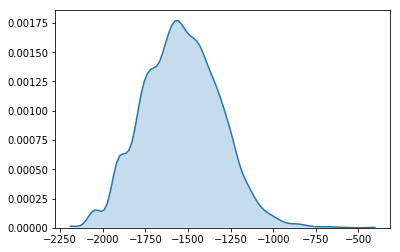

In [3]:
sns.kdeplot(energy_pbe0, shade=True, cut=0)

In this section we will be using sklearn model to do
test/train splitting of our data

The example below will randomly select 33 percent of the given data
to be used as a test, the rest will be assigned to be used as training data

In [4]:
# observable we are trying to predict
y = energy_pbe0
# molecular descriptor from qml
X = np.array([mol.representation for mol in compounds]) 

# split our data into testing data and training data with sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

With our data now in good form, we are ready to find the fitting 
parameters. We are going to use Kernel Ridge Regression as implemented
in the sklearn package.

In [5]:
# select the kernel you wish to use for fitting
# and any preprocessing can be done here
# I only introduce this approach so others can play with 
# different kernels as a learning exercise
# KRR shown here
kernel = KernelRidge(gamma=4000) 

# find the fitting coeffecients
kernel.fit(X_train, y_train)

# and make predictions on test data
predictions = kernel.predict(X_test)

We have now predicted the energies for the test set, let us now see how well the model worked

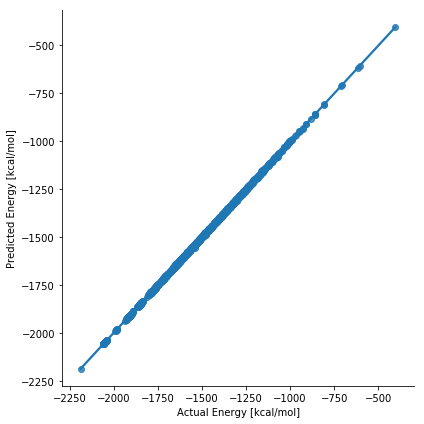

In [6]:
data=pd.DataFrame(data={'Actual Energy [kcal/mol]': y_test, 'Predicted Energy [kcal/mol]': predictions})
sns.lmplot(x="Actual Energy [kcal/mol]",y="Predicted Energy [kcal/mol]", truncate=True, data=data, size=6)

In [7]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions), "kcal/mol")
print('MSE:', metrics.mean_squared_error(y_test, predictions), "kcal/mol")
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)), "kcal/mol")

MAE: 1.2197670467978843 kcal/mol
MSE: 3.07408431636567 kcal/mol
RMSE: 1.7533066806368103 kcal/mol


Now you can go back to the top and play with using different molecular descriptors, training set size, or kernels inside of QML to see how they impact performance. 

Enjoy!